# VISION TRANSFORMERS MAIZE LEAF DISEASE DETECTION SYSTEM

## Install dependencies

In [2]:
!pip install transformers timm torch torchvision torchaudio
!pip install accelerate scikit-learn
!pip install opendatasets


## Imports

In [3]:
import os
import torch
from torch.utils.data import random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


## Config & Paths

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import opendatasets as od

# Specify the path in your Google Drive where you want to save the dataset
drive_data_dir = "/content/drive/MyDrive/corn-or-maize-leaf-disease-dataset"

od.download("https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset", data_dir=drive_data_dir)

print(f"Dataset downloaded to: {drive_data_dir}")

Skipping, found downloaded files in "/content/drive/MyDrive/corn-or-maize-leaf-disease-dataset/corn-or-maize-leaf-disease-dataset" (use force=True to force download)
Dataset downloaded to: /content/drive/MyDrive/corn-or-maize-leaf-disease-dataset


In [6]:
# Path to Kaggle dataset
data_dir = "/content/drive/MyDrive/corn-or-maize-leaf-disease-dataset/corn-or-maize-leaf-disease-dataset/data"

# Class labels
labels_map = {
    0: "Common Rust",
    1: "Gray Leaf Spot",
    2: "Blight",
    3: "Healthy"
}
num_labels = len(labels_map)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Load Feature Extractor & Transforms

In [7]:
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## EDA

In [8]:
# Load all images
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

### View Random Images with Class Names

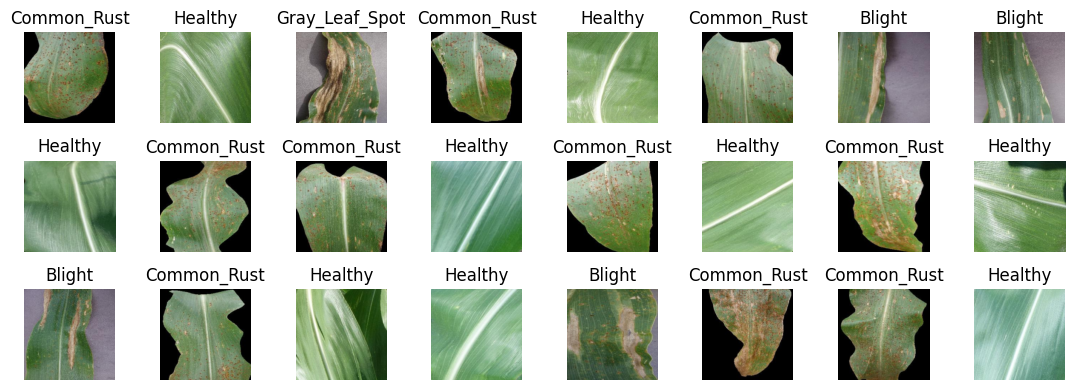

In [9]:
import matplotlib.pyplot as plt
import random

def show_random_images(dataset, classes, num_images=24, rows=3, cols=8):
    plt.figure(figsize=(11, 4))  # Adjust size to fit grid nicely
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]

        # Undo normalization for display
        img = img.permute(1, 2, 0) * torch.tensor(image_processor.image_std) + torch.tensor(image_processor.image_mean)
        img = img.clamp(0, 1)  # keep values in [0,1]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_random_images(full_dataset, full_dataset.classes)


### Class Distribution

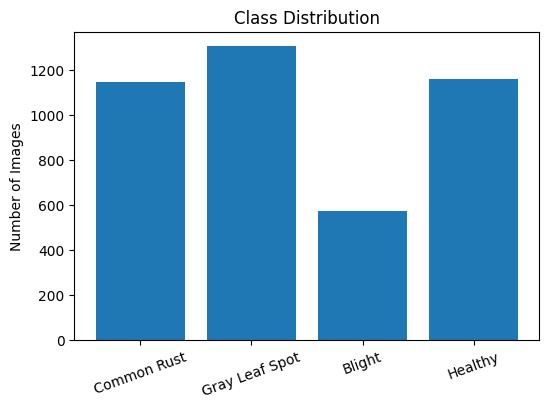

In [10]:
from collections import Counter

labels_list = [label for _, label in full_dataset]
label_counts = Counter(labels_list)

plt.figure(figsize=(6, 4))
plt.bar([labels_map[i] for i in label_counts.keys()], label_counts.values())
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.title("Class Distribution")
plt.show()


## Load Dataset & Split

In [11]:
# Train/Val/Test split (70% / 15% / 15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 2931, Val: 628, Test: 629


## Convert to HuggingFace Dataset

In [12]:
from datasets import load_dataset, Image

# Load the dataset using load_dataset which is more memory efficient
# We will use the ImageFolder format as the data is organized by folders
hf_dataset = load_dataset("imagefolder", data_dir=data_dir)

# Split the dataset into train, validation, and test sets
train_testvalid = hf_dataset["train"].train_test_split(test_size=0.3, seed=42)
hf_train_dataset = train_testvalid["train"]
test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)
hf_val_dataset = test_valid["train"]
hf_test_dataset = test_valid["test"]

print(f"Train: {len(hf_train_dataset)}, Val: {len(hf_val_dataset)}, Test: {len(hf_test_dataset)}")

# The loaded dataset will have an 'image' column. We need to rename it to 'pixel_values' to match the model's expected input.
hf_train_dataset = hf_train_dataset.rename_column("image", "pixel_values")
hf_val_dataset = hf_val_dataset.rename_column("image", "pixel_values")
hf_test_dataset = hf_test_dataset.rename_column("image", "pixel_values")

# Also, convert the image column from PIL to a tensor after applying transforms
def preprocess_images(examples):
    # Ensure the image is in RGB format before applying transforms
    examples['pixel_values'] = [transform(img.convert("RGB")) for img in examples['pixel_values']]
    return examples

hf_train_dataset.set_transform(preprocess_images)
hf_val_dataset.set_transform(preprocess_images)
hf_test_dataset.set_transform(preprocess_images)

Resolving data files:   0%|          | 0/4188 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train: 2931, Val: 628, Test: 629


## Model Initialization

In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
).to(device)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Metrics Function

In [14]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="weighted")
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


## Training Arguments

In [18]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)


## Trainer

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    processing_class=image_processor,
    compute_metrics=compute_metrics
)


## Train Model

In [20]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.096900,0.210875,0.929936,0.939649,0.929936,0.924914
2,0.026800,0.128566,0.963376,0.964841,0.963376,0.962290
3,0.010300,0.102427,0.971338,0.971492,0.971338,0.971176
4,0.003500,0.118104,0.966561,0.967286,0.966561,0.965873
5,0.000300,0.112542,0.968153,0.968732,0.968153,0.967555


TrainOutput(global_step=920, training_loss=0.052855969246466766, metrics={'train_runtime': 706.5116, 'train_samples_per_second': 20.743, 'train_steps_per_second': 1.302, 'total_flos': 1.1356654646576333e+18, 'train_loss': 0.052855969246466766, 'epoch': 5.0})

## Evaluate on Test Set

In [21]:
results = trainer.evaluate(hf_test_dataset)
print("Test Results:", results)


Test Results: {'eval_loss': 0.11374978721141815, 'eval_accuracy': 0.9650238473767886, 'eval_precision': 0.9655322545130736, 'eval_recall': 0.9650238473767886, 'eval_f1': 0.9644536478026854, 'eval_runtime': 10.9718, 'eval_samples_per_second': 57.329, 'eval_steps_per_second': 3.646, 'epoch': 5.0}


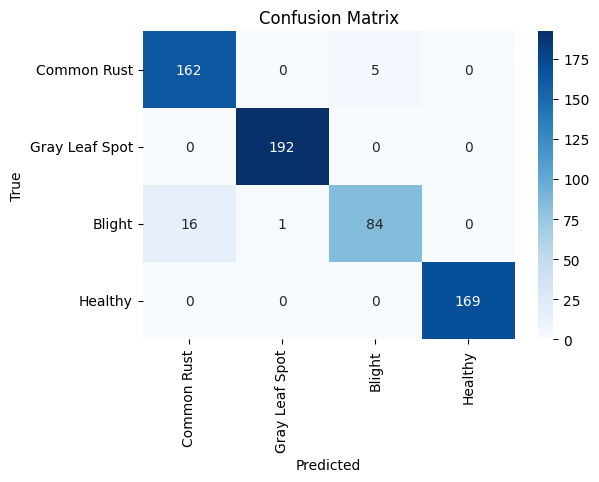

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
preds_output = trainer.predict(hf_test_dataset)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(-1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

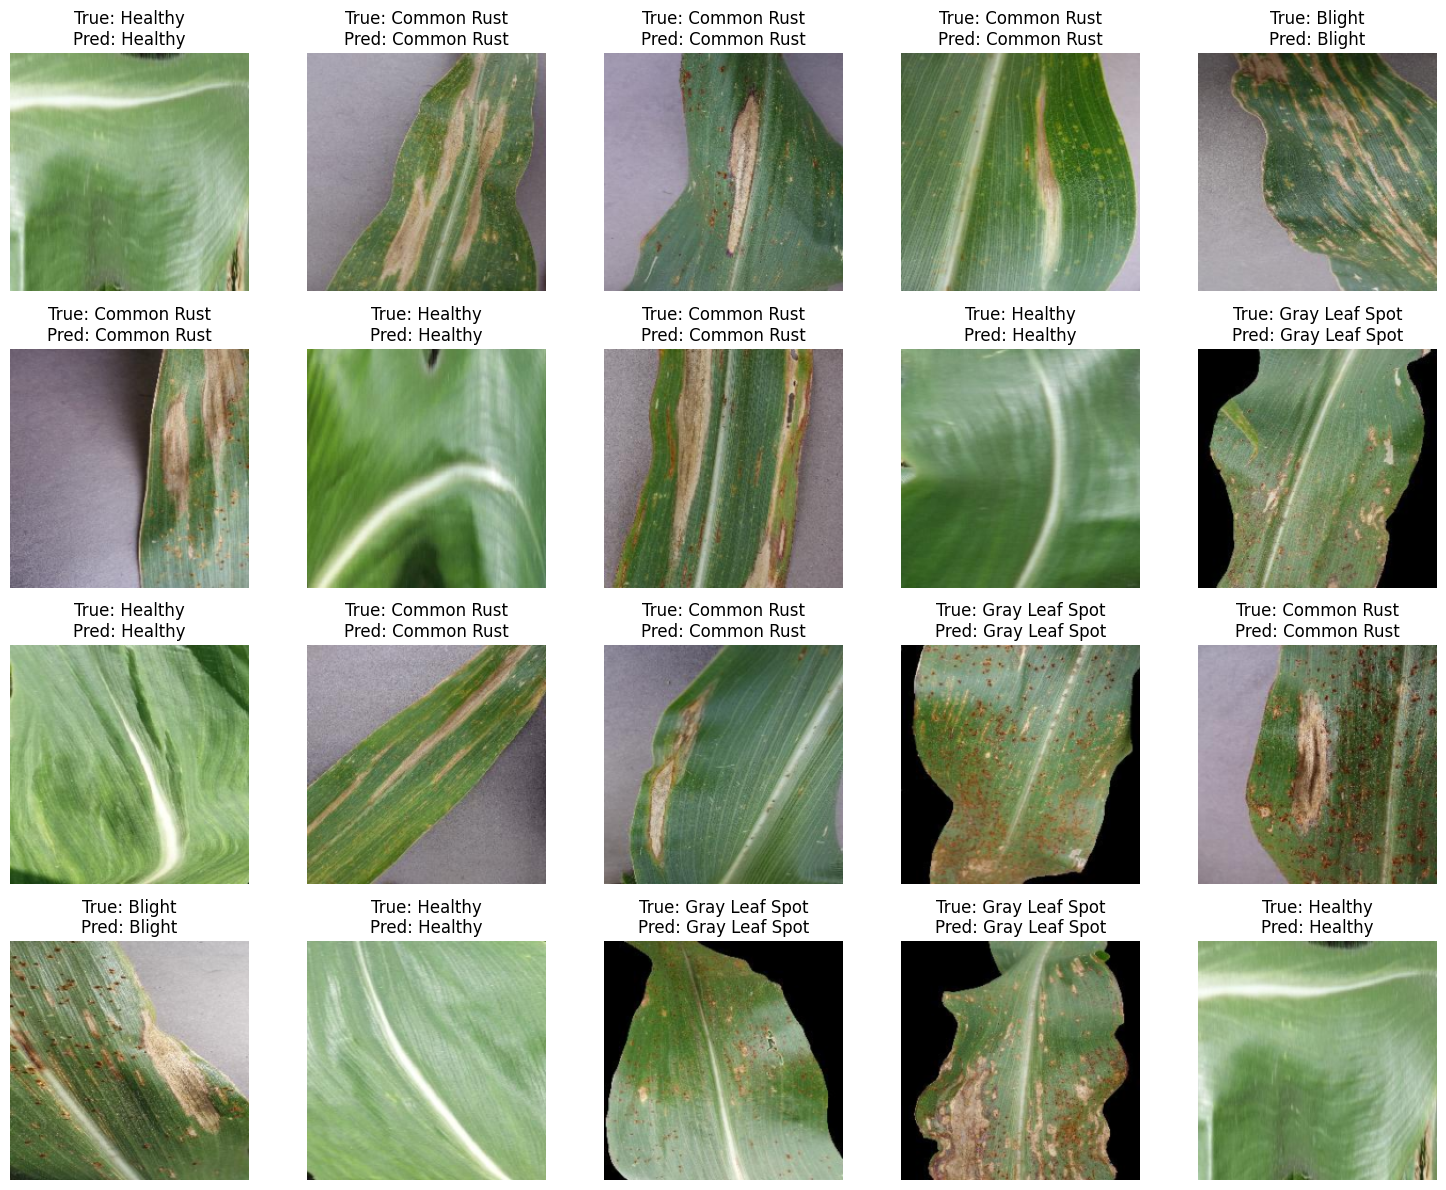

In [33]:
def show_predictions(dataset, preds, rows=4, cols=5):
    num_images = rows * cols
    plt.figure(figsize=(cols * 3, rows * 3)) # Adjust figure size based on grid
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        data = dataset[idx]  # Get the dictionary containing 'pixel_values' and 'label'
        img_tensor = data['pixel_values'] # Access the image tensor
        label = data['label'] # Access the label
        pred_label = preds[idx]

        # Undo normalization for display
        img = img_tensor.permute(1, 2, 0) * torch.tensor(image_processor.image_std) + torch.tensor(image_processor.image_mean)
        img = img.clamp(0,1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {labels_map[label]}\nPred: {labels_map[pred_label]}")
        plt.axis("off")
    plt.tight_layout() # Adjust layout to prevent titles overlapping
    plt.show()

show_predictions(hf_test_dataset, y_pred, rows=4, cols=5)

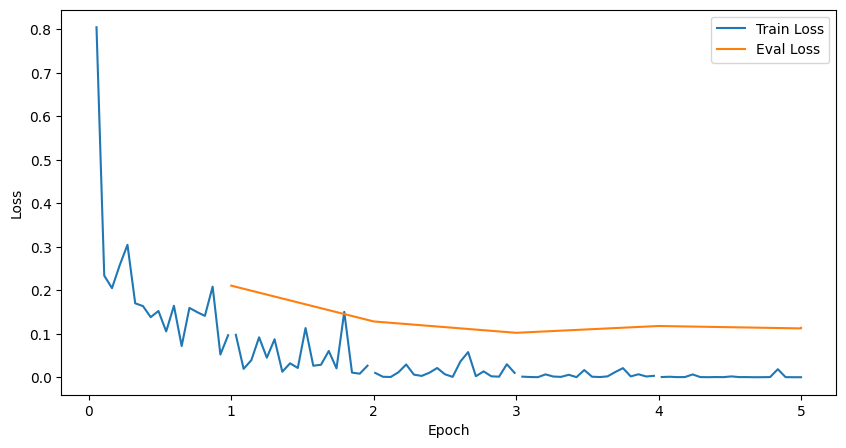

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming logs are stored in trainer.state.log_history
logs = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(10,5))
plt.plot(logs["epoch"], logs["loss"], label="Train Loss")
# Filter out rows where eval_loss is NaN before plotting
plt.plot(logs["epoch"][logs["eval_loss"].notna()], logs["eval_loss"][logs["eval_loss"].notna()], label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Save Model for Deployment

In [24]:
save_dir = "/content/drive/MyDrive/corn-or-maize-leaf-disease-dataset/maize_vit_model"
model.save_pretrained(save_dir)
image_processor.save_pretrained(save_dir)
print(f"Model saved to {save_dir}")

Model saved to /content/drive/MyDrive/corn-or-maize-leaf-disease-dataset/maize_vit_model
